# **Lending Club Loan Default Prediction and Interest Rate Analysis**

LendingClub is an American peer-to-peer lending company. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market.

LendingClub enables borrowers to create unsecured personal loans while investors can choose the loan to invest based on the information provided about the borrower, loan amount, loan grade and loan purpose. Investors make money from interest. LendingClub makes money by charging startup fees from borrowers and service fees from investors.

For investors, the top concern might be whether borrowers would default on loans or not. If default does happen, inverstors would lose their investment. On the other hand, borrowers may care more about whether they could get a loan and what will influence the interest rate of the loan.

In this project, we will take a look at how to address these questions through exploratory data analysis and bulid a machine learning model for loan default prediction.



## *Table of Contents*

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Feature Engineering](#Feature-Engineering)<br>
III. [Model Fitting](#Model-Fitting)<br>
IV. [Model Evaluation](#Model-Evaluation)<br>
V. [Conclusion](#Conclusion)<br>


## Import packages and load the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 60) 
pd.set_option('display.max_rows', 100) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/open?id=1ZEnM9ZFRgwpN5dTq_BQWsp9LMPE0NRsS'
_, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('Loan.csv') 
RawLoan = pd.read_csv('Loan.csv')
RawLoan.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42538, 56)

In [4]:
# Show the first five rows
RawLoan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag
0,NaN,5000.000,5000.000,4975.000,36 months,10.65%,162.870,B,B2,NaN,10+ years,RENT,24000.000,Verified,Dec-2011,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.650,0.000,Jan-1985,1.000,nan,nan,3.000,0.000,13648.000,83.7%,9.000,f,0.000,0.000,5863.155,5833.840,5000.000,863.160,0.000,0.000,0.000,Jan-2015,171.620,NaN,Jul-2017,0.000,1.000,INDIVIDUAL,0.000,0.000,0.000,0.000,0.000,N
1,NaN,2500.000,2500.000,2500.000,60 months,15.27%,59.830,C,C4,Ryder,< 1 year,RENT,30000.000,Source Verified,Dec-2011,Charged Off,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.000,0.000,Apr-1999,5.000,nan,nan,3.000,0.000,1687.000,9.4%,4.000,f,0.000,0.000,1014.530,1014.530,456.460,435.170,0.000,122.900,1.110,Apr-2013,119.660,NaN,Oct-2016,0.000,1.000,INDIVIDUAL,0.000,0.000,0.000,0.000,0.000,N
2,NaN,2400.000,2400.000,2400.000,36 months,15.96%,84.330,C,C5,NaN,10+ years,RENT,12252.000,Not Verified,Dec-2011,Fully Paid,n,NaN,small_business,real estate business,606xx,IL,8.720,0.000,Nov-2001,2.000,nan,nan,2.000,0.000,2956.000,98.5%,10.000,f,0.000,0.000,3005.667,3005.670,2400.000,605.670,0.000,0.000,0.000,Jun-2014,649.910,NaN,Jun-2017,0.000,1.000,INDIVIDUAL,0.000,0.000,0.000,0.000,0.000,N
3,NaN,10000.000,10000.000,10000.000,36 months,13.49%,339.310,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.000,Source Verified,Dec-2011,Fully Paid,n,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.000,0.000,Feb-1996,1.000,35.000,nan,10.000,0.000,5598.000,21%,37.000,f,0.000,0.000,12231.890,12231.890,10000.000,2214.920,16.970,0.000,0.000,Jan-2015,357.480,NaN,Apr-2016,0.000,1.000,INDIVIDUAL,0.000,0.000,0.000,0.000,0.000,N
4,NaN,3000.000,3000.000,3000.000,60 months,12.69%,67.790,B,B5,University Medical Group,1 year,RENT,80000.000,Source Verified,Dec-2011,Fully Paid,n,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.940,0.000,Jan-1996,0.000,38.000,nan,15.000,0.000,27783.000,53.9%,38.000,f,0.000,0.000,4066.908,4066.910,3000.000,1066.910,0.000,0.000,0.000,Jan-2017,67.300,NaN,Jan-2017,0.000,1.000,INDIVIDUAL,0.000,0.000,0.000,0.000,0.000,N


In [0]:
# drop id column
Loan = RawLoan.drop(columns=['id'])
# drop empty rows
Loan = Loan.dropna(axis=0,how='all')

In [0]:
# Turn the interest rate into a numerical feature
Loan['int_rate'] = Loan['int_rate'].apply(lambda x: float(x[:-1])/100)

In [0]:
# check for missing value
def check_missing_value(df):
    missing_value_column_name = []
    for i,j in zip(df.columns,df.isnull().sum(axis=0)):
        if j > 0:
            print(i,j,df[i].dtype)
            missing_value_column_name.append(i)
    print("The number of columns with missing values:",len(missing_value_column_name))

# ***I. Exploratory Data Analysis***



From the bar chart below, we notice that quite a high proprotion of the loan applicants is on the purpose of paying their other sources of debts.

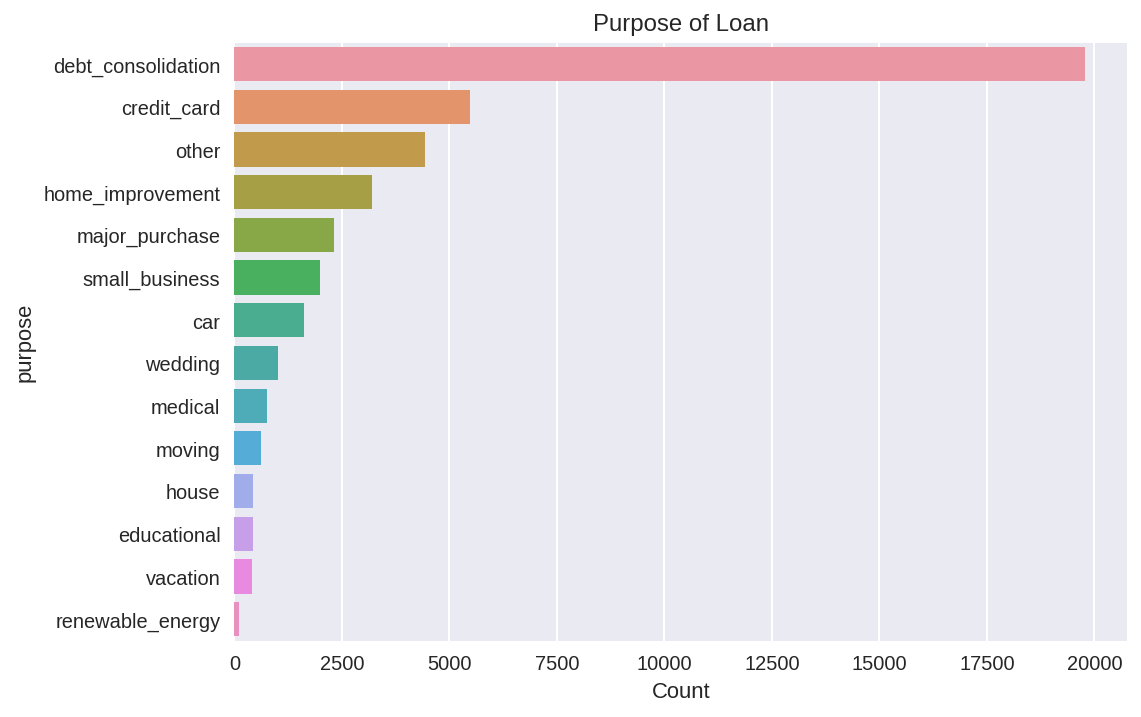

In [8]:
# Loan Purpose 
plt.style.use('seaborn')
sns.countplot(y="purpose", data = Loan,order=Loan["purpose"].value_counts().index)
plt.xlabel('Count')
plt.title('Purpose of Loan');

The interest rate shows a  strong correlation with the credit grade. The higher the credit grade, the lower the interest rate.

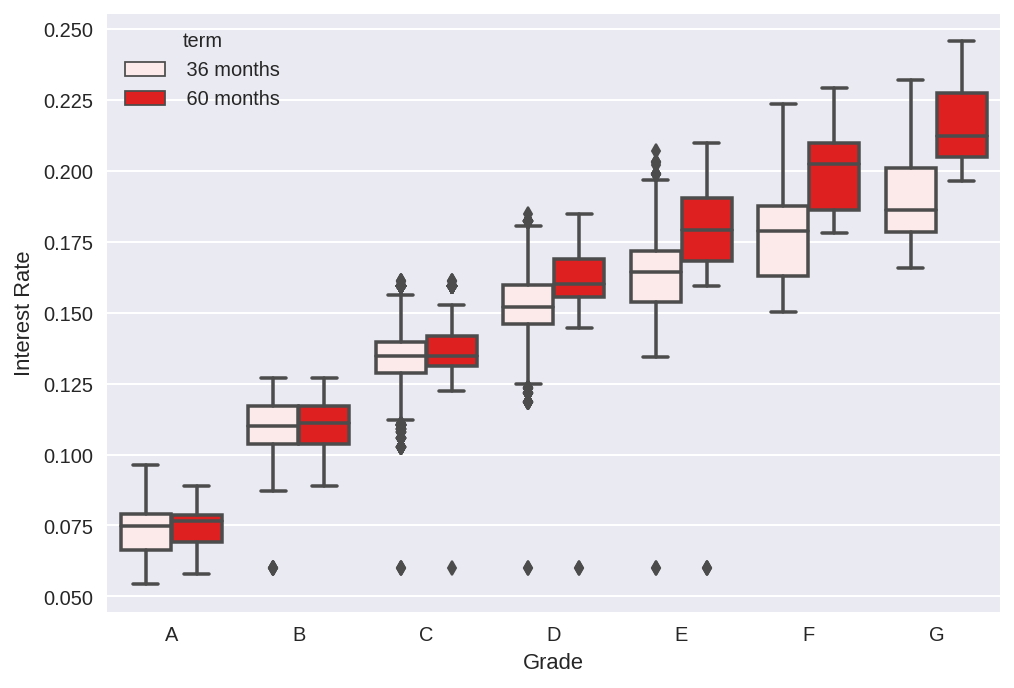

In [10]:
sns.boxplot(x='grade', y='int_rate', data=Loan,order=['A','B','C','D','E','F','G'], hue='term',color='r')
plt.xlabel('Grade')
plt.ylabel('Interest Rate');

In [11]:
Loan.groupby('term').mean()['int_rate']

term
 36 months   0.112
 60 months   0.149
Name: int_rate, dtype: float64

On average, the interest rate of a 60-month term loan is 3.7 % higher than that of a 36-month term loan. We can also see that the interest rates differ among different loan purposes. The maximum loan limit is up to $35,000

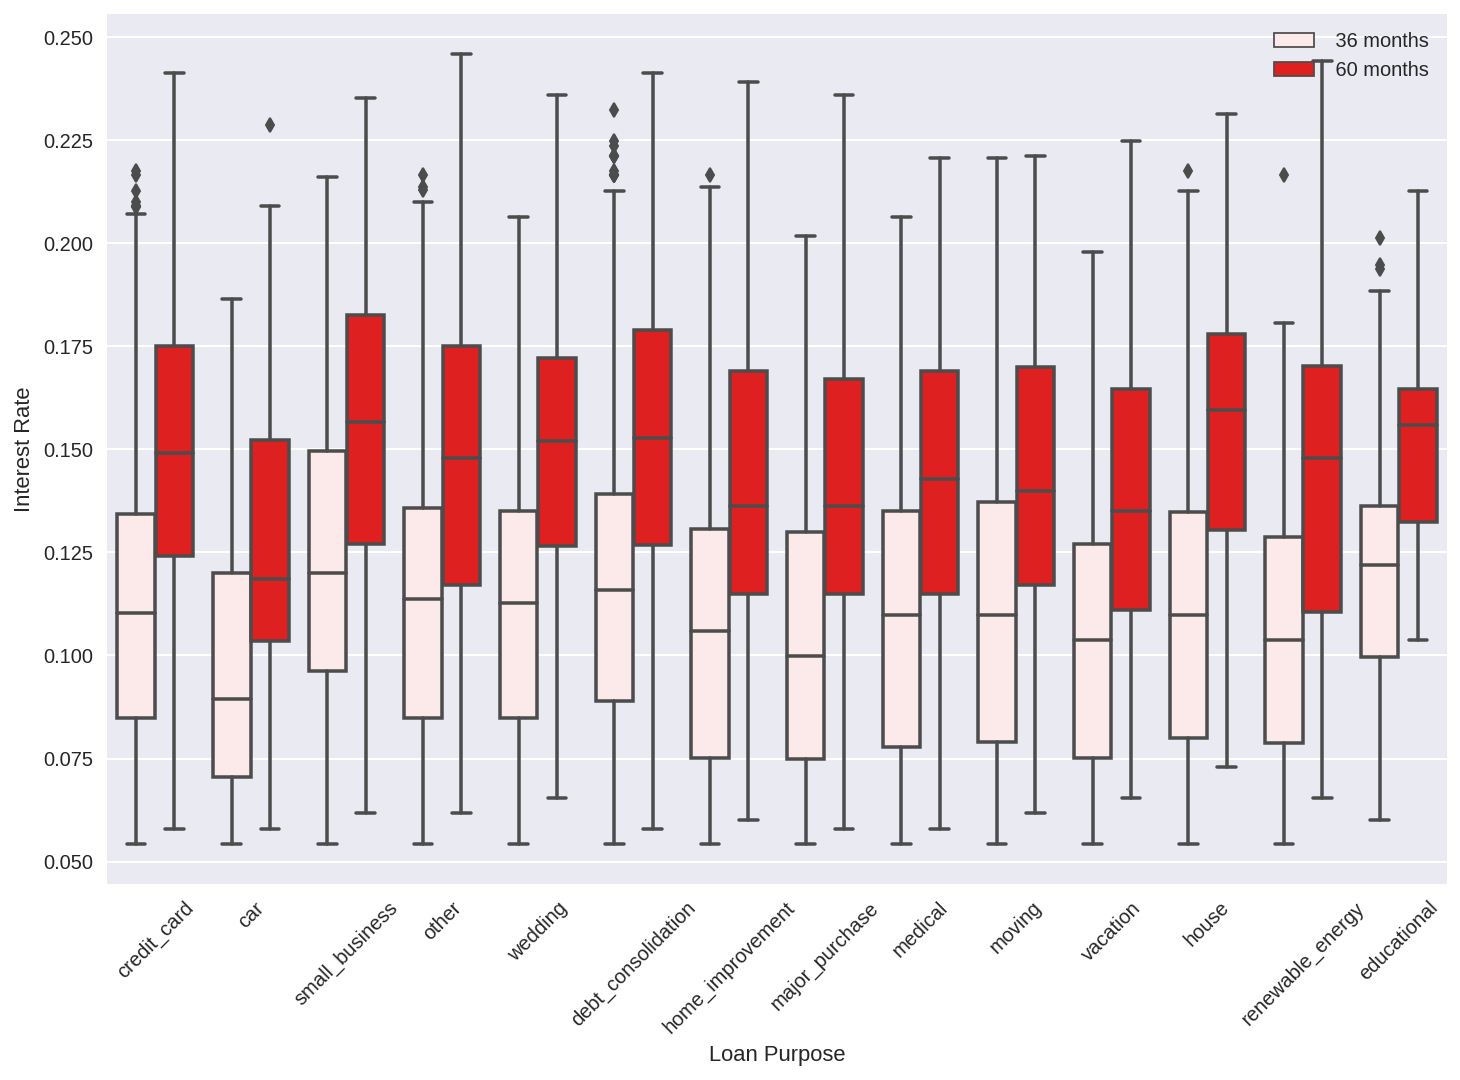

In [13]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='purpose', y='int_rate', data=Loan, hue='term',color='r')
plt.ylabel('Interest Rate')
plt.xlabel('Loan Purpose')
plt.xticks(rotation = 45)
plt.legend(loc='upper right');

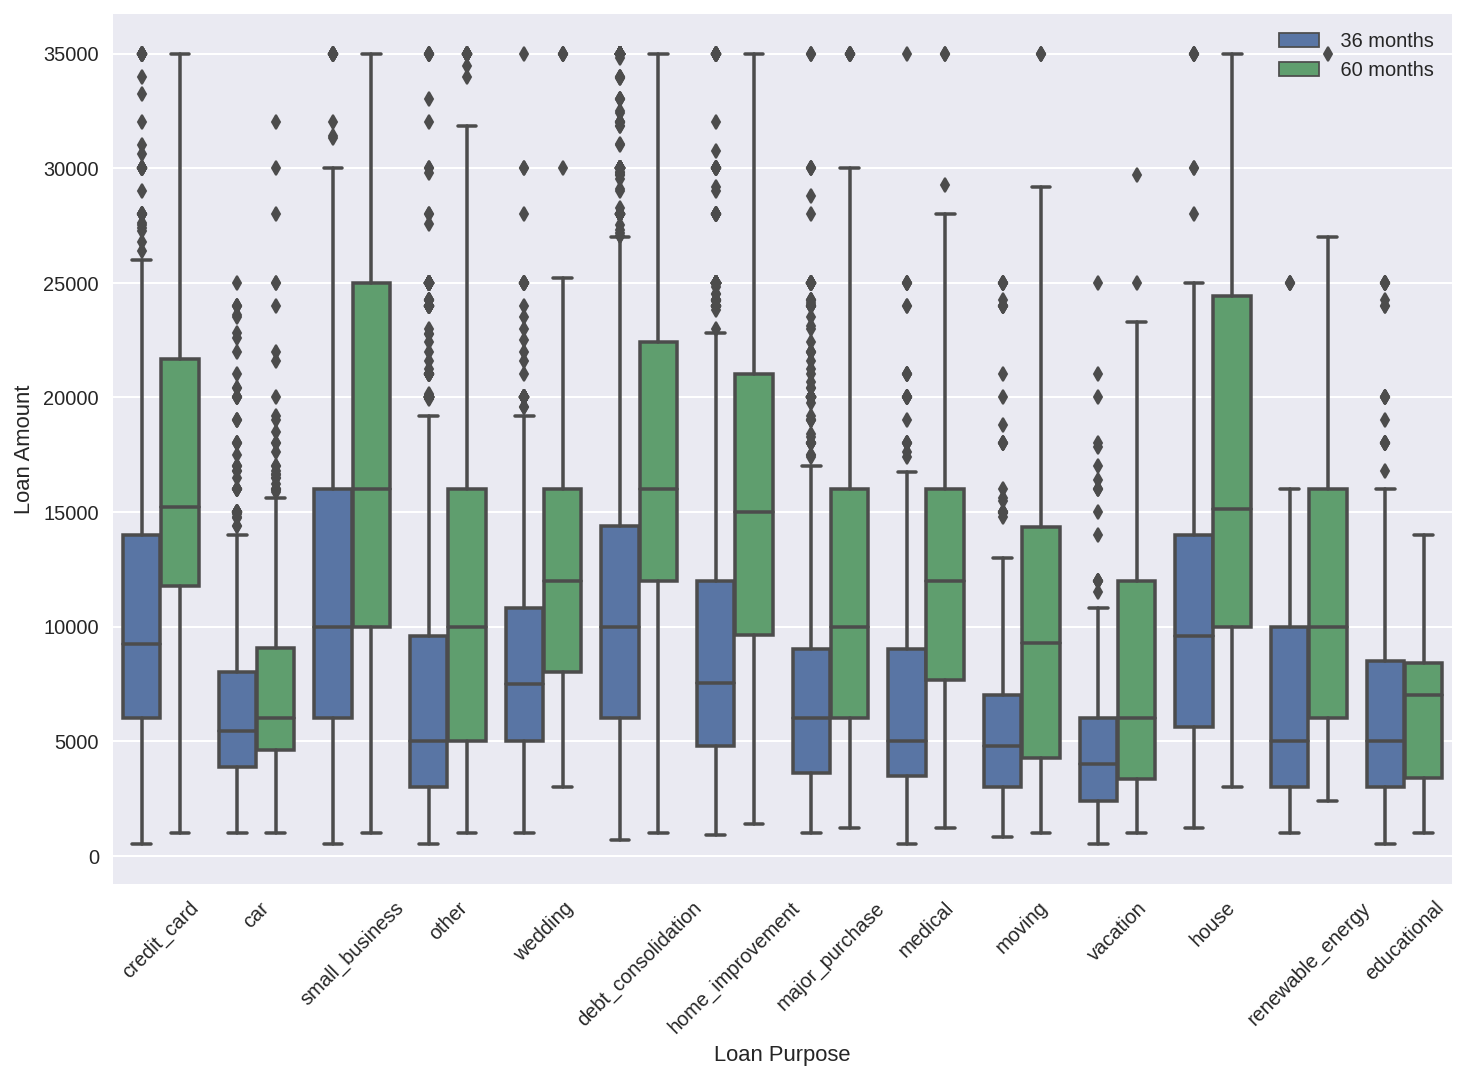

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='purpose', y='loan_amnt', data=Loan, hue='term')
plt.ylabel('Loan Amount')
plt.xlabel('Loan Purpose')
plt.xticks(rotation = 45)
plt.legend(loc='upper right');

The geographical distribution of lenders is consistent with America's demographic profile.

In [15]:
df_location = Loan.groupby(["addr_state"]).sum().reset_index()
df_location = df_location.filter(["addr_state", "loan_amnt"], axis = 1)

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df_location['addr_state'], # Spatial coordinates
    z = df_location['loan_amnt'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'Total amount issued by State',
    geo_scope='usa', # limited map scope to USA
)

fig.show()

The debt to income ratio is calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. Most of these borrowers have a rough 15% debt to income ratio. We can see that maximum is no greater than 30%. 

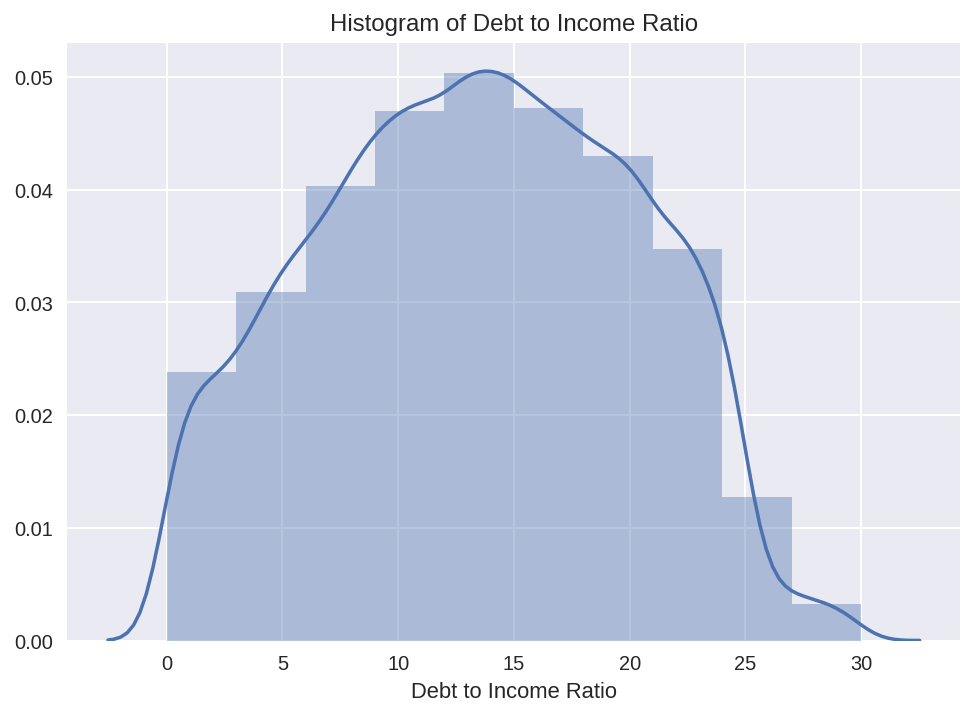

In [20]:

sns.distplot(Loan['dti'], bins=10)
plt.xlabel("Debt to Income Ratio")
plt.title("Histogram of Debt to Income Ratio");

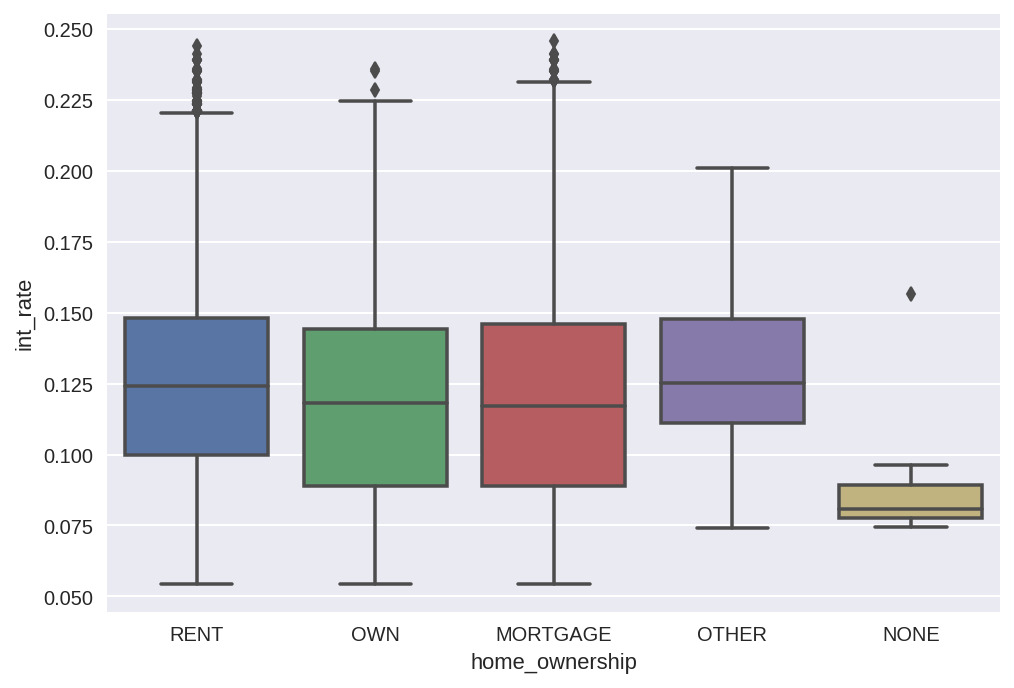

In [21]:
sns.boxplot(x='home_ownership',y='int_rate',data=Loan)

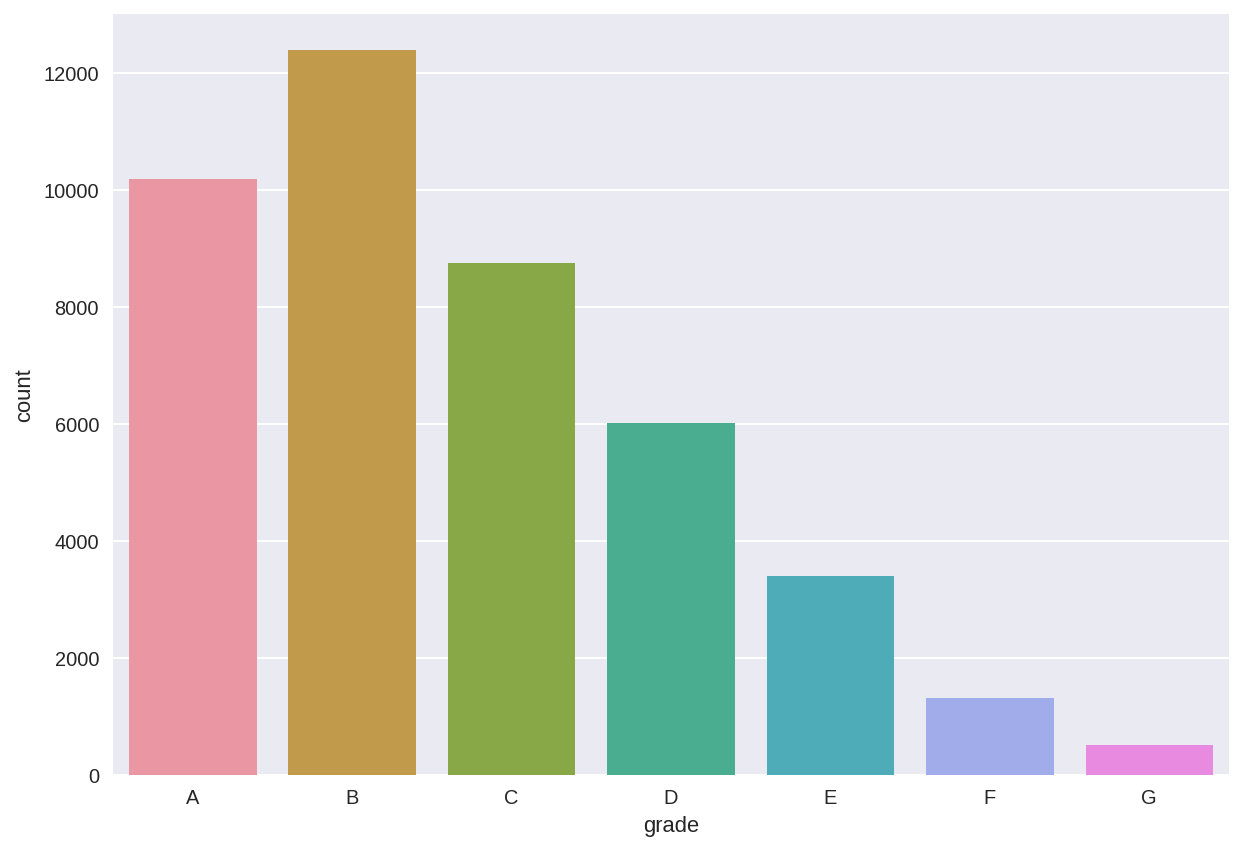

In [22]:
plt.figure(figsize=(10, 7))
sns.countplot(x="grade", data= Loan, order=['A','B','C','D','E','F','G'])

Fully Paid                                            0.802
Charged Off                                           0.133
Does not meet the credit policy. Status:Fully Paid    0.047
Does not meet the credit policy. Status:Charged Off   0.018
Name: loan_status, dtype: float64

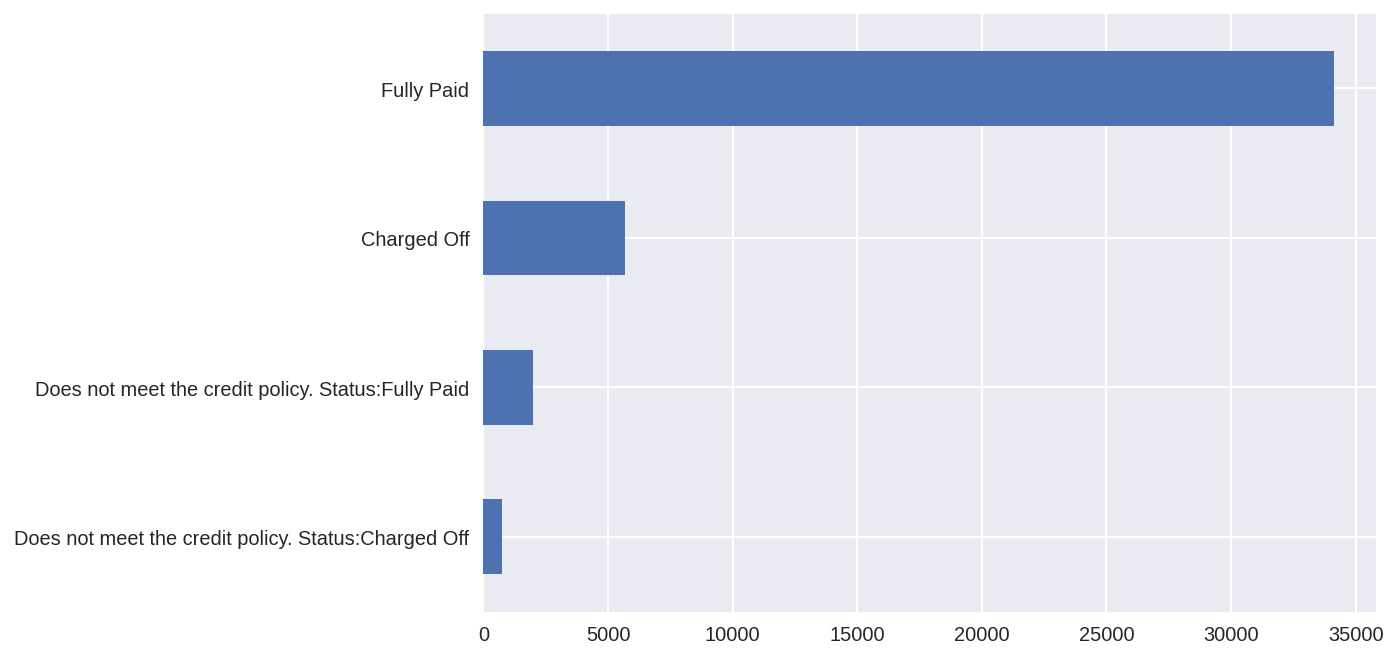

In [23]:
Loan["loan_status"].value_counts(ascending=True).plot(kind='barh')
Loan["loan_status"].value_counts()/Loan.shape[0]

There are four unique levels in the column we are interested to predict. As we are only interested in the fully paid and charged off levels, we will eliminate these to two levels later.

# ***II. Feature Engineering***


In [24]:
Loan.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,42535.000,42535.000,42535.000,42535.000,42535.000,42531.000,42535.000,42506.000,42506.000,15609.000,3651.000,42506.000,42506.000,42535.000,42506.000,42535.000,42535.000,42535.000,42535.000,42535.000,42535.000,42535.000,42535.000,42535.000,42535.000,42390.000,42535.000,42506.000,42390.000,42506.000,41170.000,42430.000
mean,11089.723,10821.586,10139.831,0.122,322.623,69136.556,13.373,0.152,1.081,35.018,59.176,9.344,0.058,14297.861,22.124,0.000,0.000,12019.008,11311.863,9675.676,2239.981,1.517,101.834,14.176,2613.246,0.000,1.000,0.000,0.000,0.143,0.045,0.000
std,7410.938,7146.915,7131.686,0.037,208.927,64096.350,6.726,0.512,1.527,22.418,47.145,4.496,0.246,22018.441,11.593,0.000,0.000,9094.163,9038.152,7105.750,2585.057,7.830,729.079,161.179,4385.067,0.000,0.000,0.010,0.000,29.360,0.209,0.005
min,500.000,500.000,0.000,0.054,15.670,1896.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,5200.000,5000.000,4950.000,0.096,165.520,40000.000,8.200,0.000,0.000,17.000,0.000,6.000,0.000,3635.000,13.000,0.000,0.000,5464.404,4792.255,4400.000,657.100,0.000,0.000,0.000,211.050,0.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,9700.000,9600.000,8500.000,0.120,277.690,59000.000,13.470,0.000,1.000,33.000,85.000,9.000,0.000,8821.000,20.000,0.000,0.000,9682.252,8955.870,8000.000,1339.160,0.000,0.000,0.000,528.360,0.000,1.000,0.000,0.000,0.000,0.000,0.000
75%,15000.000,15000.000,14000.000,0.147,428.180,82500.000,18.680,0.000,2.000,51.000,101.000,12.000,0.000,17251.000,29.000,0.000,0.000,16425.370,15538.820,13499.995,2803.090,0.000,0.000,0.000,3170.220,0.000,1.000,0.000,0.000,0.000,0.000,0.000
max,35000.000,35000.000,35000.000,0.246,1305.190,6000000.000,29.990,13.000,33.000,120.000,129.000,47.000,5.000,1207359.000,90.000,0.000,0.000,58886.473,58563.680,35000.020,23886.470,209.000,29623.350,7002.190,36115.200,0.000,1.000,1.000,0.000,6053.000,2.000,1.000


As we can see from the summary statistics, there are lots of missing values in the dataset that we need to deal with.

### ***Propressing***

Remove and Impute Missing Values

In [0]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - a cleaned version of the original dataframe
    
    This function cleans df using the following steps :
    1. Drop all the rows without the target loan status
    2. Drop columns with no intereting information
    3. Drop columns related to information leakage
    4. For each numerical variable, fill with the mode value of the column.
    5. For each categorical variable, fill with the mode value of the column.
    6. Convert 'emp_length', 'earliest_cr_line' and 'revol_util' to numerical variables.
    7. Oridinal encoding categorical variables.
    '''

    # Drop rows without target loan status 
    mask1 = df['loan_status'] == 'Fully Paid'
    mask2 = df['loan_status'] == 'Charged Off'
    df = df.loc[mask1 | mask2 ]
    
    # Drop columns 
    df = df.drop(columns=['desc','sub_grade','emp_title','zip_code', 
                          'addr_state','issue_d','pymnt_plan','policy_code',
                          'next_pymnt_d','title','initial_list_status',
                          'last_pymnt_d','application_type','hardship_flag',
                          'tax_liens'], axis=1)
    
    # Drop columns including up-to-date information of the loan status
    df = df.drop(columns=['total_rec_prncp','recoveries','total_pymnt',
                          'total_pymnt_inv','total_rec_int','last_pymnt_amnt',
                          'total_rec_late_fee','last_credit_pull_d',
                          'mths_since_last_delinq','delinq_2yrs',
                          'mths_since_last_record','collection_recovery_fee',
                          'chargeoff_within_12_mths','collections_12_mths_ex_med',
                          'out_prncp','out_prncp_inv','acc_now_delinq','delinq_amnt'], axis=1)
    
    # Fill numerical columns with the mode
    num_vars = df.select_dtypes(include=['number']).columns
    for col in num_vars:
        df[col].fillna((df[col].mode()[0]), inplace=True)
    
    # Fill categorical columns with the mode
    cat_vars = df.select_dtypes(include=['object']).columns
    for col in cat_vars:
        df[col].fillna((df[col].mode()[0]), inplace=True)
    
    # Convert to numerical variables.
    import re
    df['emp_length'] = df['emp_length'].apply(lambda x: re.findall(r'\d+', x)[0])
    df['emp_length'] = df['emp_length'].astype(int)
    df['earliest_cr_line'] = df['earliest_cr_line']\
                    .apply(lambda x: (2020-float(re.findall(r'\d+', x)[0])))
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
    
    # Ordinal encoding
    cat_vars = list(df.select_dtypes(include=['object']).columns)
    cat_vars.remove('loan_status')
    for var in cat_vars:
        class_mapping = {label:idx for idx, label in enumerate(np.unique(df[var]))}
        print(class_mapping)
        df[var]=df[var].map(class_mapping)

    return df

In [26]:
cleaned_loan = clean_data(Loan)

{' 36 months': 0, ' 60 months': 1}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
{'MORTGAGE': 0, 'NONE': 1, 'OTHER': 2, 'OWN': 3, 'RENT': 4}
{'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
{'car': 0, 'credit_card': 1, 'debt_consolidation': 2, 'educational': 3, 'home_improvement': 4, 'house': 5, 'major_purchase': 6, 'medical': 7, 'moving': 8, 'other': 9, 'renewable_energy': 10, 'small_business': 11, 'vacation': 12, 'wedding': 13}


In [27]:
check_missing_value(cleaned_loan)

The number of columns with missing values: 0


In [28]:
cleaned_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
0,5000.000,5000.000,4975.000,0,0.106,162.870,1,10,4,24000.000,2,Fully Paid,1,27.650,35.000,1.000,3.000,0.000,13648.000,0.837,9.000,0.000
1,2500.000,2500.000,2500.000,1,0.153,59.830,2,1,4,30000.000,1,Charged Off,0,1.000,21.000,5.000,3.000,0.000,1687.000,0.094,4.000,0.000
2,2400.000,2400.000,2400.000,0,0.160,84.330,2,10,4,12252.000,0,Fully Paid,11,8.720,19.000,2.000,2.000,0.000,2956.000,0.985,10.000,0.000
3,10000.000,10000.000,10000.000,0,0.135,339.310,2,10,4,49200.000,1,Fully Paid,9,20.000,24.000,1.000,10.000,0.000,5598.000,0.210,37.000,0.000
4,3000.000,3000.000,3000.000,1,0.127,67.790,1,1,4,80000.000,1,Fully Paid,9,17.940,24.000,0.000,15.000,0.000,27783.000,0.539,38.000,0.000


In [0]:
# One hot encoding for Y
class_mapping = {"Fully Paid":0, "Charged Off":1}
cleaned_loan['loan_status']=cleaned_loan['loan_status'].map(class_mapping)

In [30]:
cleaned_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
0,5000.000,5000.000,4975.000,0,0.106,162.870,1,10,4,24000.000,2,0,1,27.650,35.000,1.000,3.000,0.000,13648.000,0.837,9.000,0.000
1,2500.000,2500.000,2500.000,1,0.153,59.830,2,1,4,30000.000,1,1,0,1.000,21.000,5.000,3.000,0.000,1687.000,0.094,4.000,0.000
2,2400.000,2400.000,2400.000,0,0.160,84.330,2,10,4,12252.000,0,0,11,8.720,19.000,2.000,2.000,0.000,2956.000,0.985,10.000,0.000
3,10000.000,10000.000,10000.000,0,0.135,339.310,2,10,4,49200.000,1,0,9,20.000,24.000,1.000,10.000,0.000,5598.000,0.210,37.000,0.000
4,3000.000,3000.000,3000.000,1,0.127,67.790,1,1,4,80000.000,1,0,9,17.940,24.000,0.000,15.000,0.000,27783.000,0.539,38.000,0.000


## ***Train-test Split***

In [0]:
from sklearn.model_selection import train_test_split

Y = cleaned_loan["loan_status"]
X = cleaned_loan.drop(["loan_status"], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=2020, test_size=.30, stratify = Y)

## ***Transformation***

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ***III. Model Fitting***

In [0]:
from sklearn import metrics
from sklearn.metrics import roc_curve


def plot_ROC(model, labels):
    """Plot ROC"""
    Y_train_pred = model.predict_proba(X_train)[:, 1]
    fpr, tpr, _ = roc_curve(Y_train, Y_train_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=labels)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - {} model'.format(labels))
    plt.legend(loc='best')
    plt.show()
    print("AUC score is",metrics.auc(fpr,tpr))
    return

In [0]:
def plot_feature_importance(model,file_name) :
    "Plot the feature importance plot and save the file"   
    # feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    model_name = file_name.split(".")
    temp=pd.DataFrame(importances[indices],X.columns[indices])
    temp.columns = ["Feature importance"]
    temp["Feature name"] = temp.index    
    plt.subplots(figsize=(10, 8))
    ax = sns.barplot(y = "Feature name" ,x = "Feature importance", data = temp.iloc[:20,])
    plt.title("Feature Importance_"+model_name[0])
    plt.savefig(file_name)
    return 

In [0]:
def training_score(model):
    print("Training accuracy is {:.3f}".format(model.score(X_train, Y_train)))

    
def testing_score(model):
    print("Testing accuracy is {:.3f}".format(model.score(X_test, Y_test)))    

## ***Light GBM***

In [0]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [0]:
# Use grid search and 5 fold cross validation to find the best model
parameters = {
    "n_estimators": (50, 100, 200),
    "max_depth" : (5,),
    "reg_lambda" : (0.1,0.01)
}
model_lgb =lgb.LGBMClassifier(eval_metric = "auc")

Grid_lgbm = GridSearchCV(model_lgb,parameters, cv=5,  scoring = "roc_auc")

In [67]:
Grid_lgbm.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0, eval_metric='auc',
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': (5,), 'n_estimators': (50, 100, 200),

In [68]:
best_lgbm = Grid_lgbm.best_estimator_
best_lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0,
               reg_lambda=0.01, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

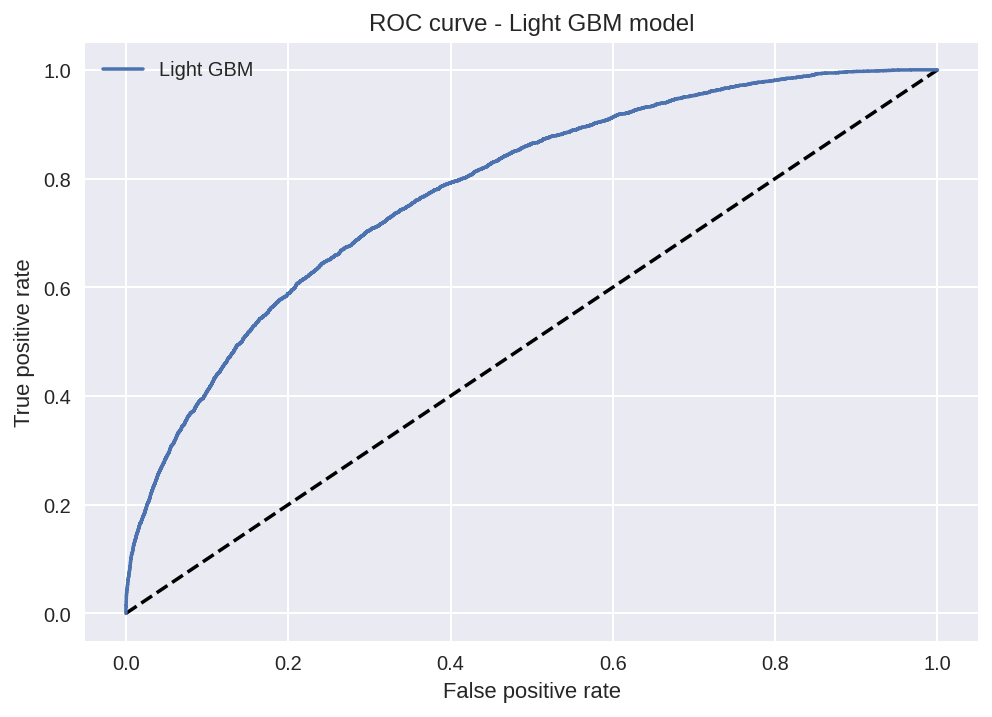

AUC score is 0.7786792514479995


In [69]:
plot_ROC(best_lgbm, "Light GBM")

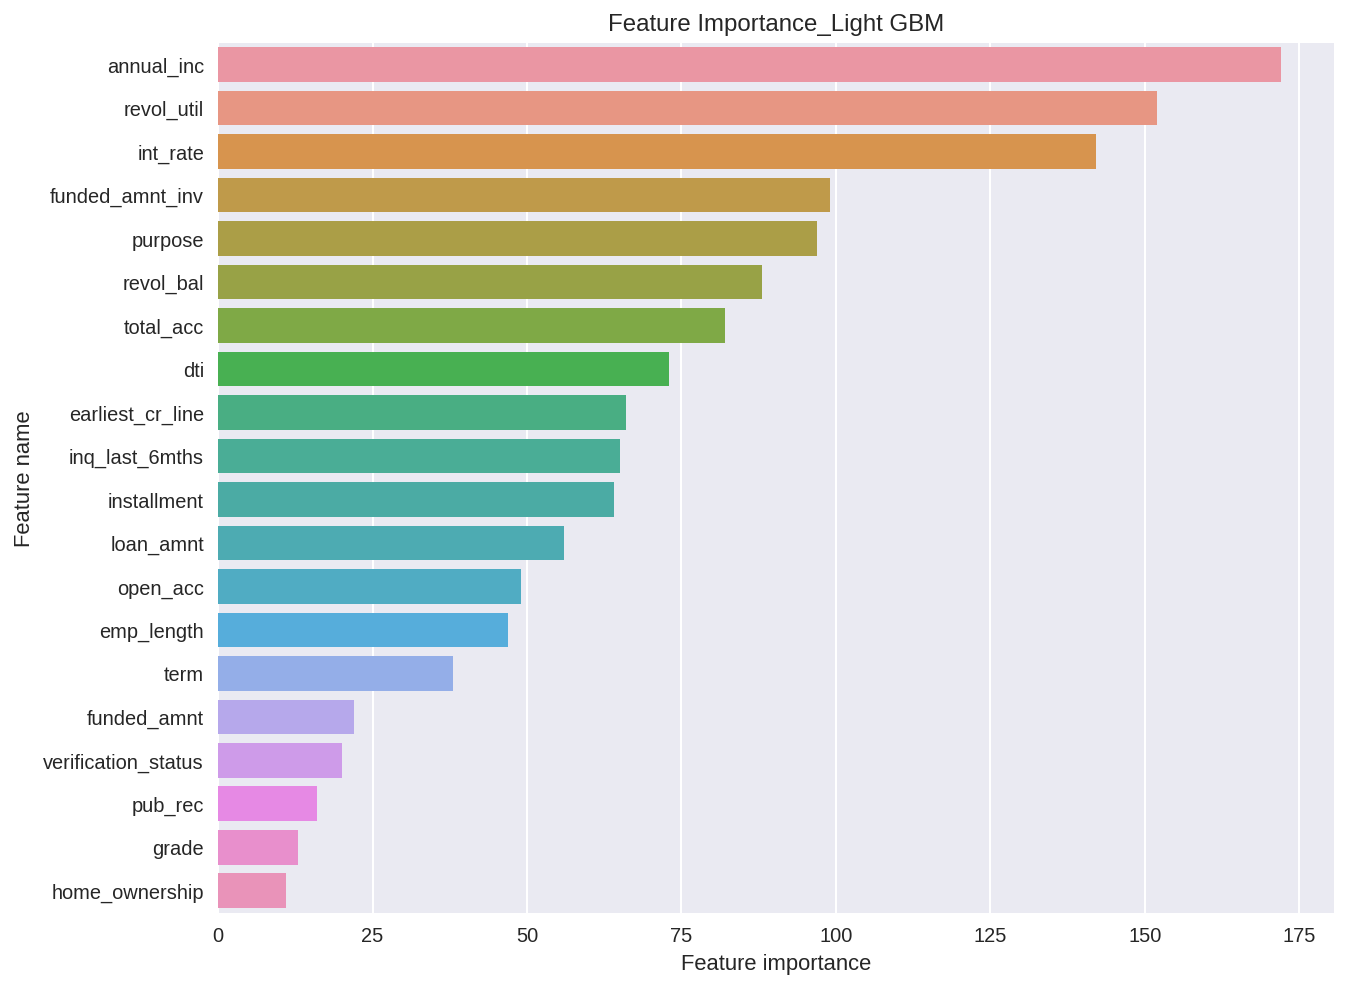

In [70]:
plot_feature_importance(best_lgbm,"Light GBM.pdf")

In [71]:
training_score(best_lgbm)

Training accuracy is 0.859


## ***Nerual Network***

In [72]:
from sklearn.neural_network import MLPClassifier

# build a multilayer perceptron classifier with 3 hidden layers
mlp = MLPClassifier(hidden_layer_sizes=(20,30,20))
mlp.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 30, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

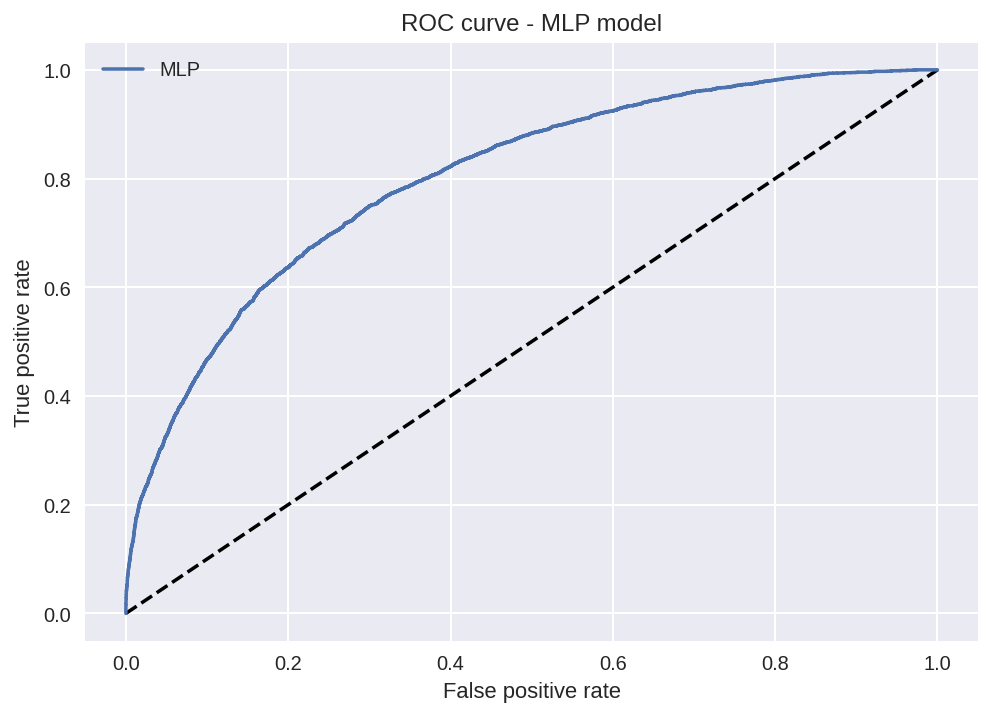

AUC score is 0.8013720588570888


In [73]:
plot_ROC(mlp,"MLP")

In [74]:
training_score(mlp)

Training accuracy is 0.871


# ***IV. Model Evaluation***

In [0]:
import itertools
from sklearn.metrics import precision_recall_fscore_support


def confusion_plot(model):
    """Plot the confusion plot of the test set"""
    Y_test_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test,Y_test_pred)
    model_eval = precision_recall_fscore_support(Y_test,Y_test_pred)
    print("The precision is", model_eval[0])
    print("The recall is", model_eval[1])
    print("The F1 score is", model_eval[2])
    cmap = plt.cm.Reds

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(['No','Yes']))
    plt.xticks(tick_marks, ['No','Yes'], rotation=45)
    plt.yticks(tick_marks, ['No','Yes'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")
    ax = plt.axes()
    t = 'Confusion Matrix:'
    ax.set_title(t ,fontweight="bold", size=10)
    plt.show()

## ***Light GBM***

In [78]:
# Make predictions on the testing set
Y_pred_lightgbm = best_lgbm.predict(X_test)
testing_score(best_lgbm)

Testing accuracy is 0.857


In [54]:
print(classification_report(Y_test,Y_pred_lightgbm))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10235
           1       0.41      0.01      0.02      1701

    accuracy                           0.86     11936
   macro avg       0.63      0.50      0.47     11936
weighted avg       0.79      0.86      0.79     11936



The precision is [0.85819892 0.40625   ]
The recall is [0.99814362 0.00764256]
The F1 score is [0.92289625 0.01500289]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



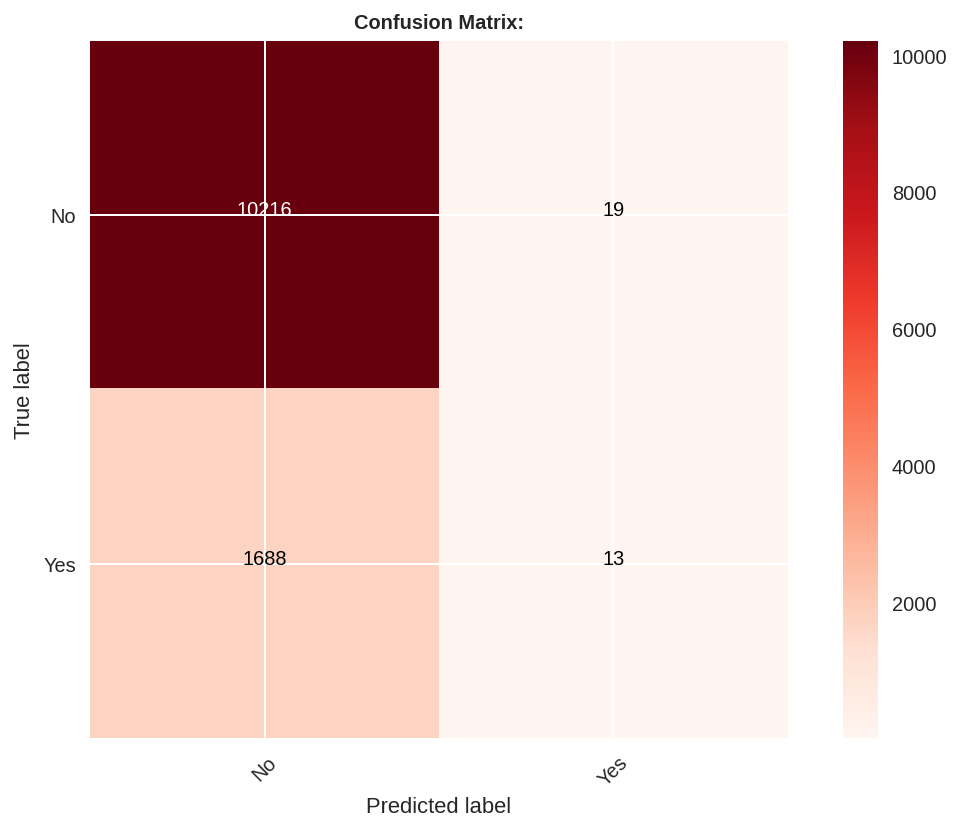

In [52]:
confusion_plot(best_lgbm)

## ***Nerual Network***

In [79]:
# Make predictions on the testing set
Y_pred_nn = mlp.predict(X_test)
testing_score(mlp)

Testing accuracy is 0.842


In [80]:
print(classification_report(Y_test,Y_pred_nn))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     10235
           1       0.27      0.06      0.10      1701

    accuracy                           0.84     11936
   macro avg       0.56      0.52      0.51     11936
weighted avg       0.78      0.84      0.80     11936



The precision is [0.86178791 0.26550868]
The recall is [0.97107963 0.06290417]
The F1 score is [0.9131753  0.10171103]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



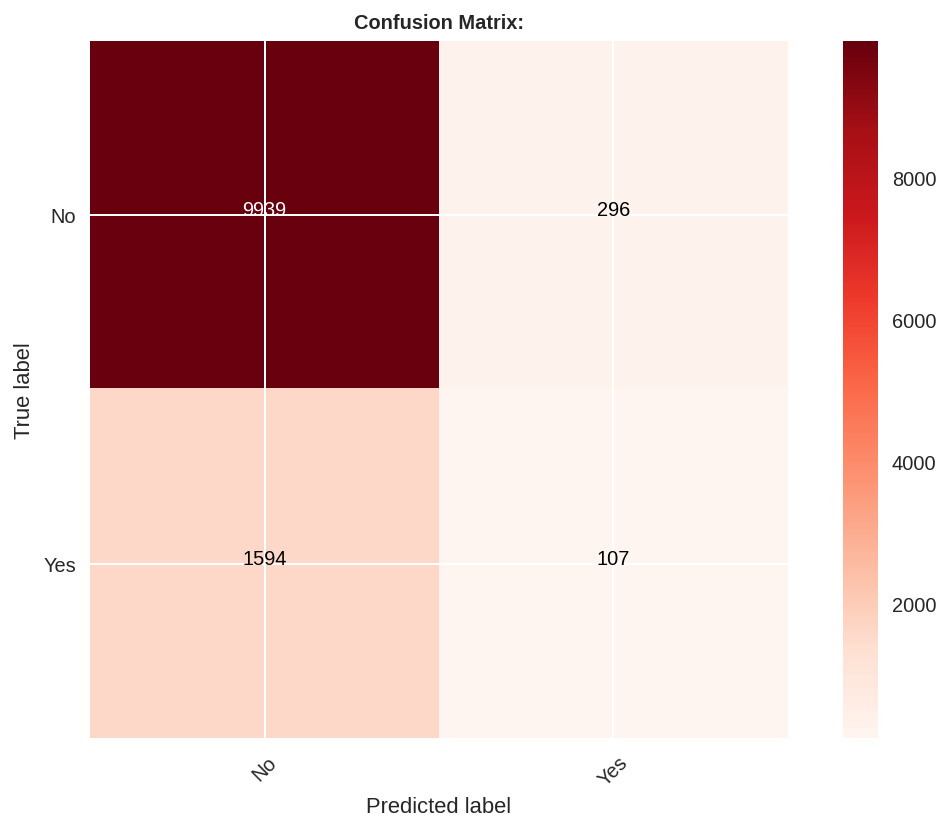

In [81]:
confusion_plot(mlp)

# ***V. Conclusion***



When comparing the results from Light GBM with these from MLP, we can see that MLP did a better job on the training set with a 87.1 % training accuray but the  accuracy dropped by about 3 % on the testing set. 

From the confusion matrix, we know our classifers have really high precision but low recall. This means the proportion of true non-default among the predict non-default is high. But when the true label is charge-off, our classifers are not sensitive enough to notice that. This might be caused by the imbalanced class size in our dataset. Actually in this case, we do care more about the precision as we want to invest to those who are less likely to default.

During the prepossessing , one important thing to notice is information leakage. As our dataset contains much up-to-date information related to the number of delinquency month and charge off collection fee etc, these features suggest a charge off loan. But at the time we decide to make the investment, we don't have these information. So it is better to remove these columns when building the model.

To summarize, in this project we found the interest rate had a strong connection with the applicant's credit grade. A 60-month term loan has about 3 % higer interest rate than a 48-month term loan. Most borrowers apply for a loan in order to pay other sources of debts. The geographical distribution of lenders is almost consistent with America's demographic profile.

If you are interested in this topic, you can find a larger dataset through this link with 2260668 rows. Here I am only using a subset for computational efficiency.

https://www.kaggle.com/wendykan/lending-club-loan-data?